In [2]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

import seaborn as sns

In [3]:
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', lambda x: '% .2f' % x)

In [4]:
msft = yf.Ticker("CIB")
apple = yf.Ticker("AAPL")
oil = yf.Ticker('CL=F')
gold = yf.Ticker('GC=F')

In [5]:
Acciones = [msft,apple,oil,gold]
Acciones_Nombre =['Bancolombia','Apple','petroleo','oro']
Acciones.index(msft)

0

Carga de matriz de retornos

In [6]:
k = 4
Retornos=pd.DataFrame()
for accion in Acciones:
  Retornos[Acciones_Nombre[Acciones.index(accion)]] = accion.history(period="2y", interval="1wk")[['Close']].pct_change()[1:]
Retornos

,Bancolombia,Apple,petroleo,oro
Date,,,,
2021-04-19 00:00:00-04:00,-0.07,0.00,-0.02,-0.00
2021-04-26 00:00:00-04:00,-0.05,-0.02,0.02,-0.01
2021-05-03 00:00:00-04:00,0.03,-0.01,0.02,0.04
2021-05-10 00:00:00-04:00,0.04,-0.02,0.01,0.00
2021-05-17 00:00:00-04:00,-0.07,-0.02,-0.03,0.02
...,...,...,...,...
2023-03-13 00:00:00-04:00,-0.12,0.04,-0.13,0.06
2023-03-20 00:00:00-04:00,0.02,0.03,0.04,0.01
2023-03-27 00:00:00-04:00,0.10,0.03,0.09,-0.01


In [33]:
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', lambda x: '% .4f' % x)
np.array(Retornos.mean())

array([0.00044321, 0.00259746, 0.00419133, 0.00145655])

# Matriz de covarianza

In [7]:
from scipy.stats import spearmanr
R = np.corrcoef(Retornos, rowvar=False)
Rho, p = spearmanr(Retornos, axis=0)

Text(0.5, 1.0, 'matriz de convarianza de rango')

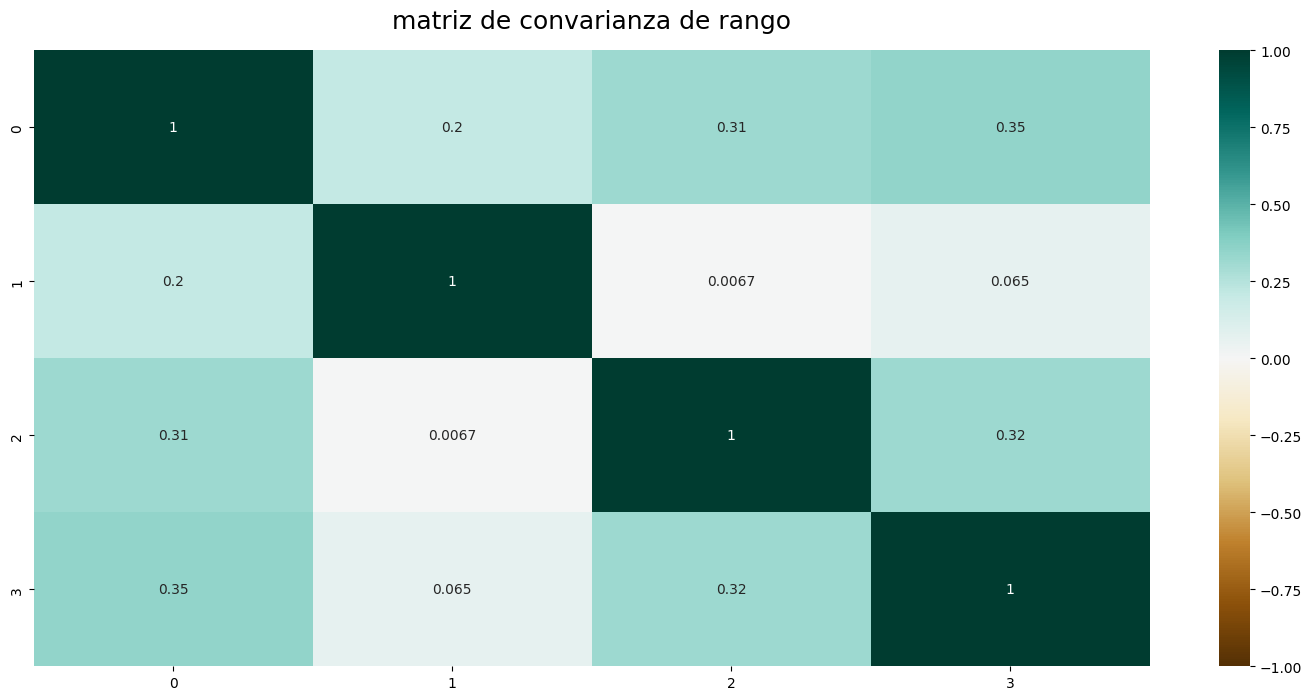

In [8]:
plt.figure(figsize=(18, 8))
#https://www.tylervigen.com/spurious-correlations
#mascara = np.triu(np.ones_like(datos_ml.corr(), dtype=bool)) mask=mascara,
heatmap = sns.heatmap(Rho, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('matriz de convarianza de rango', fontdict={'fontsize':18}, pad=16)

# Matriz de correlación Lineal

Text(0.5, 1.0, 'matriz de correlación')

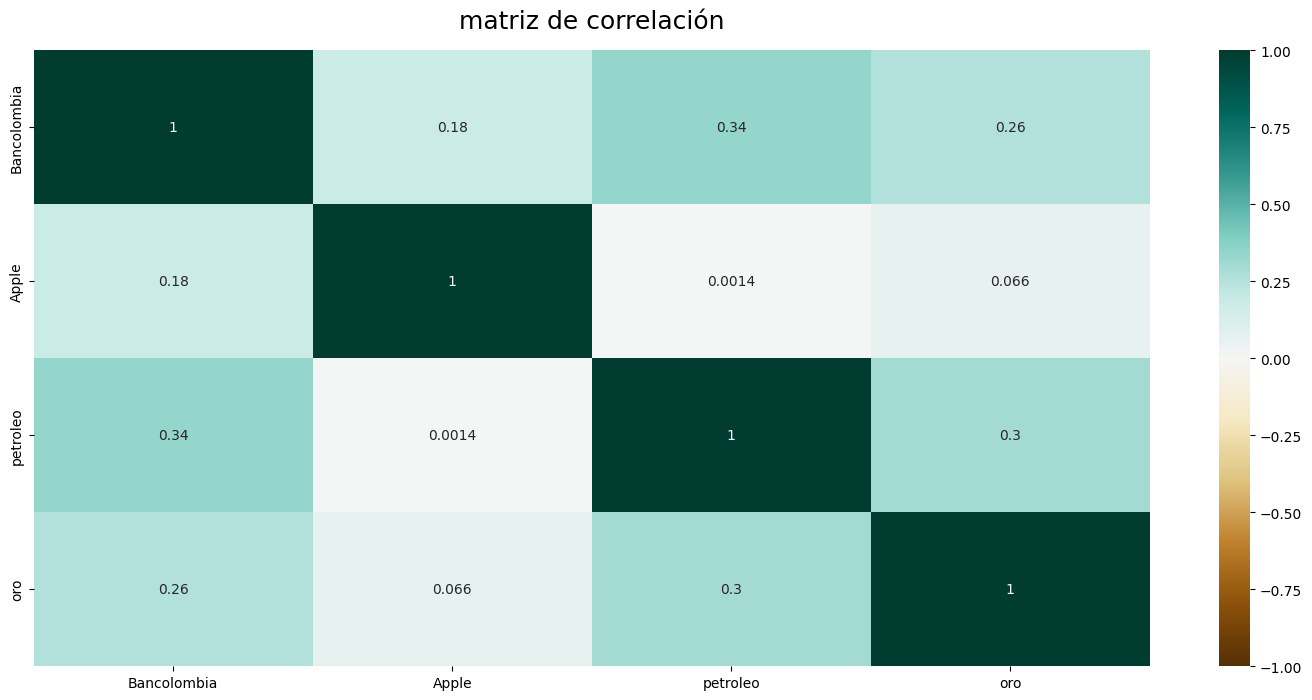

In [9]:
plt.figure(figsize=(18, 8))
#https://www.tylervigen.com/spurious-correlations
#mascara = np.triu(np.ones_like(datos_ml.corr(), dtype=bool)) mask=mascara,
heatmap = sns.heatmap(Retornos.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('matriz de correlación', fontdict={'fontsize':18}, pad=16)

## Optimizacion del portafolio

In [10]:
from scipy.stats import spearmanr

Rho, p = spearmanr(Retornos, axis=0)


$$\sigma(\overline{\omega}) = \omega^T\cdot H\cdot \omega $$
$$\mathbb{E}(r^T\cdot \omega) \geq R $$

donde:
- $R$ : son los retornos deseados
- $\omega$ son los porcentajes que quiero en cada portafolio

In [11]:
import numpy as np
from scipy.optimize import minimize 
 
# Función objetivo a minimizar
retornos  = np.array([0.2,0.4,0.2,0.4])

R = 0.2 

def sigma(w, cov):
    return np.dot(w.T, np.dot(cov, w))

def retorno(w):
    return np.dot(w.T, retornos) - R

# Restricciones de ponderación
restriccion = ({'type': 'eq', 'fun': retorno},
               {'type': 'eq', 'fun': lambda w: np.sum(w) - 1})


# Rango de ponderación de los activos (el valor de cada 0<w_i<1)
rango = tuple((0, 1) for i in range(len(retornos)))

# Solución de la optimización
w0 = np.ones(len(retornos)) / len(retornos) # Punto inicial de la optimización

result = minimize(sigma, w0, args=(Rho,), method='SLSQP', constraints=restriccion, bounds=rango)

print(result)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.65643337245279
       x: [ 5.000e-01  0.000e+00  5.000e-01  1.318e-16]
     nit: 4
     jac: [ 1.313e+00  2.117e-01  1.313e+00  6.626e-01]
    nfev: 20
    njev: 4


In [12]:

print(f"El vector de las distribuciones para mi portafolio es:\n {result.x.round(4)}")
print(f"Valor minima varianza es:\n {result.fun}")

El vector de las distribuciones para mi portafolio es:
 [0.5 0.  0.5 0. ]
Valor minima varianza es:
 0.65643337245279


- jac:  jacobiano
- fun : es $\sigma_{min}$ el valor minimo alcanzado
- nit : se iteró nit veces hasta obtener el optimo

In [13]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.65643337245279
       x: [ 5.000e-01  0.000e+00  5.000e-01  1.318e-16]
     nit: 4
     jac: [ 1.313e+00  2.117e-01  1.313e+00  6.626e-01]
    nfev: 20
    njev: 4

##  Implementacion en una clase

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

from scipy.optimize import minimize 

import seaborn as sns

msft = yf.Ticker("CIB")
apple = yf.Ticker("AAPL")
oil = yf.Ticker('CL=F')
gold = yf.Ticker('GC=F')

Acciones = [msft,apple,oil,gold]
Acciones_Nombre =['Bancolombia','Apple','petroleo','oro']
Acciones.index(msft)


## Creacion de matriz de retornos
Retornos=pd.DataFrame()
for accion in Acciones:
  Retornos[Acciones_Nombre[Acciones.index(accion)]] = accion.history(period="2y", interval="1wk")[['Close']].pct_change()[1:]
Retornos


## Matriz de covarianza
from scipy.stats import spearmanr
R = np.corrcoef(Retornos, rowvar=False)  # coeficiente de correlacion

Rho, _ = spearmanr(Retornos, axis=0)

r = np.array([0.2,0.4,0.2,0.4])  ## vector de retornos esperados que no se como calcular

class MiPortafolio:
  def __init__(self,R,Rho,r):
    self.R = R
    self.Rho = Rho
    self.retornos = r

  def valor_retorno_deseado(self):
    print(self.R)

  def sigma(self, w, cov):
    return np.dot(w.T, np.dot(cov, w))

  def retorno(self, w):
    return np.dot(w.T, retornos) - self.R

  def minimizar(self):

    # Restricciones de ponderación
    restriccion = ({'type': 'eq', 'fun': self.retorno},
               {'type': 'eq', 'fun': lambda w: np.sum(w) - 1})


  # Rango de ponderación de los activos (el valor de cada 0<w_i<1)
    rango = tuple((0, 1) for i in range(len(self.retornos)))

  # Solución de la optimización
    w0 = np.ones(len(self.retornos)) / len(self.retornos) # Punto inicial de la optimización

    result = minimize(self.sigma, w0, args=(self.Rho,), method='SLSQP', constraints=restriccion, bounds=rango)
    return(result)


portafolio1 = MiPortafolio(0.2,Rho,r)

  

In [15]:
portafolio1.minimizar()

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.6568075439959147
       x: [ 5.165e-01  0.000e+00  4.835e-01  0.000e+00]
     nit: 3
     jac: [ 1.336e+00  2.181e-01  1.290e+00  6.637e-01]
    nfev: 15
    njev: 3

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

from scipy.optimize import minimize 

import seaborn as sns

class MiPortafolio:

  def __init__(self,R,r,Nombre_Acciones):
    self.R = R
    self.Rho = Rho
    self.retornos = r
    self.acciones = Nombre_Acciones

  def matriz_retornos(self):
    Retornos=pd.DataFrame()
    for accion_name in self.acciones:
      accion = yf.Ticker(accion_name)
      Retornos[accion_name] = accion.history(period="2y", interval="1wk")[['Close']].pct_change()[1:]
    return(Retornos)

  def matriz_covarianza(self):
    Rho, _ = spearmanr(self.matriz_retornos(), axis=0)
    return(Rho)

  def valor_retorno_deseado(self):
    print(self.R)

  ## Funcion a optimizar
  def sigma(self, w, cov):
    return np.dot(w.T, np.dot(cov, w))

  ## E(r * w) = R
  def retorno(self, w):
    return np.dot(w.T, self.retornos) - self.R

  def minimizar(self):

    Rho = self.matriz_covarianza()

    # Restricciones de ponderación
    restriccion = ({'type': 'eq', 'fun': self.retorno},
               {'type': 'eq', 'fun': lambda w: np.sum(w) - 1})


    # Rango de ponderación de los activos (el valor de cada 0<w_i<1)
    rango = tuple((0, 1) for i in range(len(self.retornos)))

    # Solución de la optimización
    w0 = np.ones(len(self.retornos)) / len(self.retornos) # Punto inicial de la optimización

    result = minimize(self.sigma, w0, args=(Rho,), method='SLSQP', constraints=restriccion, bounds=rango)
    return(result)

  def sigmaMin(self):
    minima = self.minimizar()
    print(f'La minima varianza dado que R = {self.R} es {minima.fun}')
    return minima.fun

  def parametros(self):
    minima = self.minimizar()
    print(f'Los parametros para diversificar el portafolio es: \n {minima.x.round(4)}')
    return minima.x.round(4)

r = np.array([0.2,0.4,0.2,0.4])  ## vector de retornos esperados que no se como calcular
Nombre_Acciones = ['CIB','AAPL','CL=F','GC=F']


portafolio1 = MiPortafolio(0.2,r,Nombre_Acciones)
portafolio1.sigmaMin()
  

La minima varianza dado que R = 0.2 es 0.6568075439959147


0.6568075439959147

In [17]:
r = np.array([0.2,0.1,0.2,0.3])  ## vector de retornos esperados que no se como calcular
Nombre_Acciones = ['CIB','AAPL','CL=F','GC=F']

# Generar un rango de valores de retorno esperado
rango = np.linspace(0.01, 0.3, 100)
volatilidad = [MiPortafolio(x,r,Nombre_Acciones).sigmaMin() for x in rango]


La minima varianza dado que R = 0.01 es 1.0000000000000302
La minima varianza dado que R = 0.01292929292929293 es 1.000000000000064
La minima varianza dado que R = 0.015858585858585857 es 1.000000000000007
La minima varianza dado que R = 0.018787878787878787 es 1.0000000000000342
La minima varianza dado que R = 0.021717171717171718 es 1.000000000000048
La minima varianza dado que R = 0.024646464646464646 es 1.0000000000000422
La minima varianza dado que R = 0.027575757575757573 es 0.999999999999775
La minima varianza dado que R = 0.030505050505050507 es 1.0000000000000422
La minima varianza dado que R = 0.033434343434343435 es 1.0000000000000013
La minima varianza dado que R = 0.03636363636363636 es 1.0000000000000018
La minima varianza dado que R = 0.03929292929292929 es 0.9999999999995473
La minima varianza dado que R = 0.042222222222222223 es 1.0000000000000484
La minima varianza dado que R = 0.04515151515151515 es 0.9999999999997256
La minima varianza dado que R = 0.048080808080808

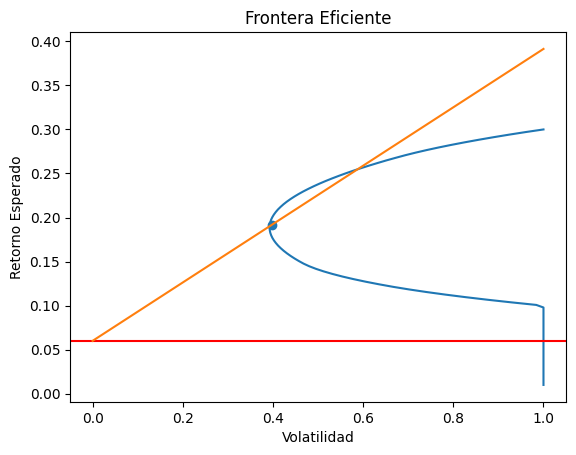

In [18]:
# Graficar la frontera eficiente

x = np.linspace(0, 1, 100)
plt.plot(volatilidad, rango)

plt.scatter(0.39714342903002087,0.1916161616161616)
plt.xlabel('Volatilidad')
plt.ylabel('Retorno Esperado')
plt.title('Frontera Eficiente')
plt.axhline(y=0.06, color='r', linestyle='-')
plt.plot(x,(1316161616161/3971434290300)*x + 0.06)
plt.show()



## Encontrar el ajuste polinomial

Los coeficientes del polinomio ajustado son:
  [ 56.48516421 -22.03353282   2.52874034]
mse:  0.0007081419142222096


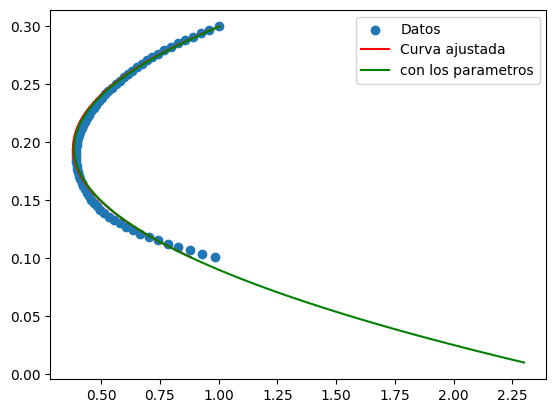

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

volatilidad, rango



# encontrar los coeficientes del polinomio [a,b,c] ax²+bx+c 
coef = np.polyfit(rango[31:], volatilidad[31:], 2)
p = np.poly1d(coef)

print('Los coeficientes del polinomio ajustado son:\n ',coef) 
print('mse: ' , mean_squared_error(p(rango[31:]),volatilidad[31:]))



# Graficar los datos y la curva ajustada
plt.scatter( volatilidad[31:],rango[31:] ,label='Datos')
plt.plot(p(rango[31:]),rango[31:], 'r-', label='Curva ajustada')
plt.plot(56.03574269*rango**2+ -21.83851528*rango+ 2.5123844,rango,'g-',label= 'con los parametros')
plt.legend()
plt.show()
